In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import QuantileTransformer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
# load data
df = pd.read_csv("Financial data final.csv")
df.set_index('Symbol',inplace = True)
spy = pd.read_csv("spy.csv")
spy.set_index('Symbol',inplace = True)
price = pd.read_csv("monthly price.csv")
price.set_index('Symbol',inplace = True)
tb=pd.read_csv('US T-bill 3 month.csv')
tb.set_index('Symbol',inplace = True)
c_list=pd.read_csv('company list.csv')
c_list.set_index('Company name',inplace = True)
senti=pd.read_csv('sentiments.csv')
senti.set_index('Company name',inplace = True)

In [3]:
# join with sentiment results
senti_c = c_list.join(senti)
senti_c.set_index('Symbol',inplace = True)
df=df.join(senti_c)

In [4]:
# scaling the data
scaler = QuantileTransformer(output_distribution='normal', random_state=0)
scaled_values = scaler.fit_transform(df) 
df.loc[:,:] = scaled_values

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (241). n_quantiles is set to n_samples.
  warnings.warn(


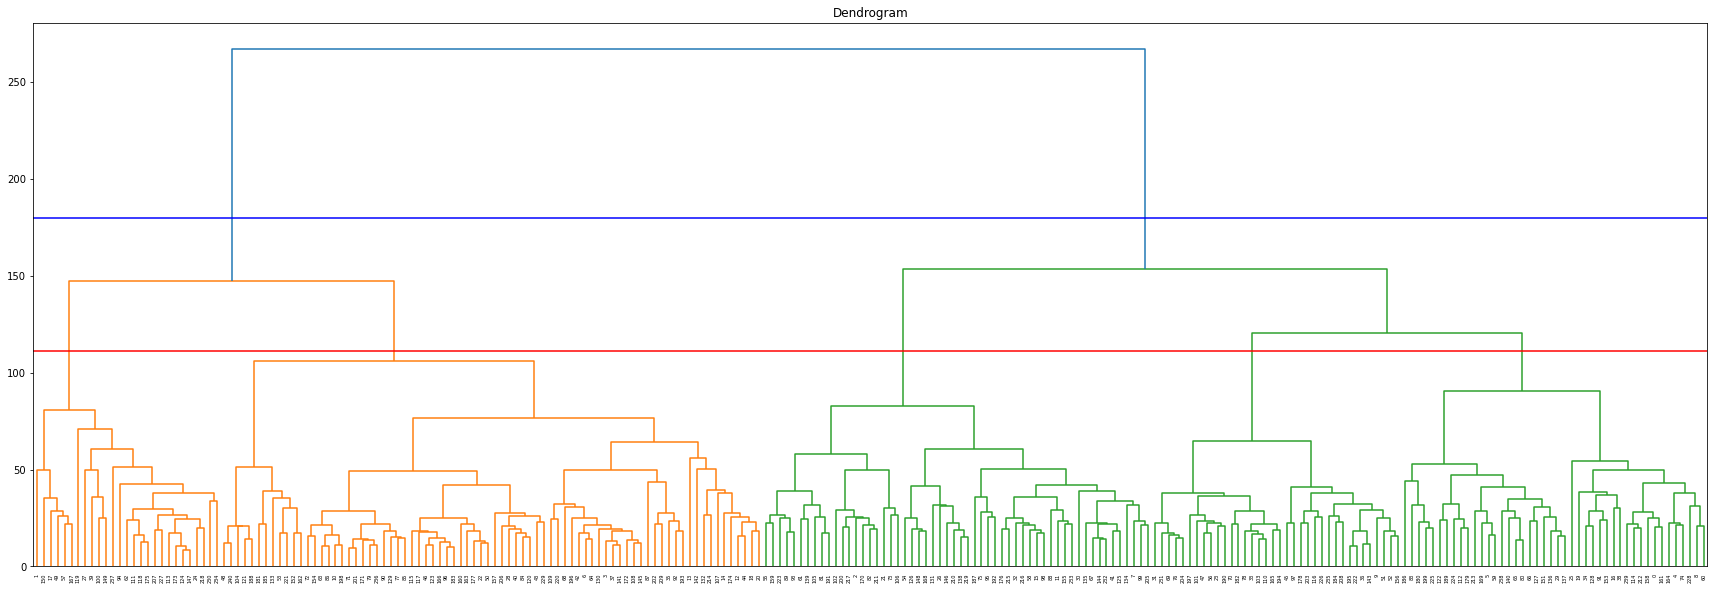

In [5]:
# plot the dendrogram
plt.figure(figsize=(30,10))
dendrogram1 = dendrogram(linkage(df, method = 'ward')) # finding the optimal number of clusters using dendrogram
plt.title('Dendrogram') # title of the dendrogram
plt.axhline(y=111, color='r', linestyle='-')
plt.axhline(y=180, color='b', linestyle='-')
plt.show() # show the dendrogram

In [6]:
# compute prices for bench marks
# for ETF: spy
share_spy = 100000/spy["1/31/2006"].values
spy.insert(0,"number of shares",share_spy)
spy = spy.mul(spy["number of shares"], axis="index")
# for all 241 companies
alldf = price.copy()
share_all = 100000/alldf["1/31/2006"].values
alldf.insert(0,"number of shares",share_all)
alldf = alldf.mul(alldf["number of shares"], axis="index")
# copy df columns for the next loop
dfcol = df.columns

total return for 5 clusters: [3.93907102 7.25479656 4.54616049 5.53485828 5.15290105]
max is 7.2547965588975325 max is at label 1
Index(['A', 'ADBE', 'ADI', 'ADSK', 'AMD', 'AMZN', 'AZO', 'BBWI', 'BIIB', 'BSX',
       'CTAS', 'CTXS', 'DGX', 'DHI', 'EA', 'EMN', 'EQR', 'FISV', 'IFF', 'INTU',
       'KLAC', 'LEN', 'LH', 'MAR', 'MAS', 'MCO', 'MSI', 'MU', 'NLOK', 'NTAP',
       'NVDA', 'PAYX', 'PKI', 'PLD', 'PSA', 'RHI', 'SPG', 'TPR', 'TROW', 'VMC',
       'VNO', 'WAT', 'YUM', 'ZBH'],
      dtype='object', name='Symbol') (array([0, 1, 2, 3, 4], dtype=int64), array([78, 44, 56, 27, 36], dtype=int64))


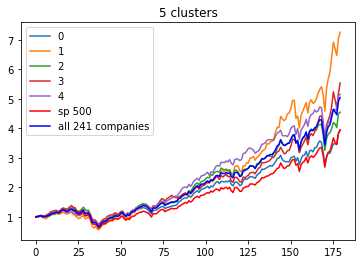

In [7]:
# validate the performance
for n in [5]:
    df_l = df.copy(deep=True)
    h_cl_l = AgglomerativeClustering(linkage="ward",n_clusters = n).fit(df_l)
    df_l["label"] = h_cl_l.labels_
    p_l = df_l.join(price)
    p_l.drop(dfcol, axis=1, inplace=True)
    price_list = []
    total_return = np.array([])
    for x in range(n):
        edf = p_l[p_l["label"] == x]
        share = 100000/edf["1/31/2006"].values
        edf.insert(1,"number of shares",share)
        edf = edf.mul(edf["number of shares"], axis="index")
        p_l_x = edf.describe().iloc[1].values[2:]
        price_list.append(p_l_x)
        price_list[x] = [z/100000 for z in price_list[x]]
        plt.plot(price_list[x],label = "{}".format(x))
        total_return = np.append(total_return,price_list[x][-1])
    print("total return for {} clusters:".format(n),total_return)
    print("max is {}".format(total_return.max()),"max is at label {}".format(total_return.argmax()) )
    print(df_l[df_l["label"] == total_return.argmax()].index,np.unique(h_cl_l.labels_, return_counts=True))
    plt.plot(spy.iloc[0].values[1:]/100000,label = "sp 500",color = 'r')
    plt.plot(alldf.describe().iloc[1].values[1:]/100000,label = "all 241 companies", color = 'b')
    plt.title("{} clusters".format(n))
    plt.rc('xtick', labelsize=10) 
    plt.rc('legend',fontsize=10)
    plt.legend()
    plt.show()

In [8]:
ha_cl1 = AgglomerativeClustering(linkage="ward",n_clusters = 5).fit(df)
np.unique(ha_cl1.labels_, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64), array([78, 44, 56, 27, 36], dtype=int64))

In [9]:
df_a = df.copy(deep=True)
df_a["label"] = ha_cl1.labels_
p_a = df_a.join(price)
p_a.drop(dfcol, axis=1, inplace=True)

## analysis

In [10]:
# test1 = p_a.loc[['VTRS','ADSK','CSCO']]
test1 = p_a[p_a["label"] == 1]
share_t = 100000/test1["1/31/2006"].values
test1.insert(1,"number of shares",share_t)
test1 = test1.mul(test1["number of shares"], axis="index")
p_l_t = test1.describe().iloc[1].values[2:]/100000

In [11]:
# price df of desired cluster, spy, all
p_t = pd.DataFrame([p_l_t,spy.iloc[0][1:]/100000,alldf.describe().iloc[1].values[1:]/100000])

In [12]:
# percent change in price df
p_t_n = p_t.pct_change(axis='columns').dropna(1)

C:\Users\Yi\AppData\Local\Temp\ipykernel_26100\4140601285.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  p_t_n = p_t.pct_change(axis='columns').dropna(1)


In [13]:
# CAGR
cagr_t = (p_l_t[-1]/p_l_t[0])**(1/15)-1
cagr_spy = (spy.iloc[0][1:][-1]/spy.iloc[0][1:][0])**(1/15)-1
cagr_all = (alldf.describe().iloc[1].values[1:][-1]/alldf.describe().iloc[1].values[1:][0])**(1/15)-1
# total return
tr_spy = spy.iloc[0].values[1:][-1]/100000
tr_all = alldf.describe().iloc[1].values[1:][-1]/100000
tr_t = p_l_t[-1]

In [14]:
# market correlation
from scipy.stats import pearsonr
corr_t, _ = pearsonr(p_t_n.transpose()[0], p_t_n.transpose()[1])
corr_spy, _ = pearsonr(p_t_n.transpose()[1], p_t_n.transpose()[1])
corr_all, _ = pearsonr(p_t_n.transpose()[2], p_t_n.transpose()[1])

In [15]:
# sharpe ratio
sr_t = (p_t_n.transpose().describe()[0][1]-0.0009)/p_t_n.transpose().describe()[0][2]*(12**0.5)
sr_spy = (p_t_n.transpose().describe()[1][1]-0.0009)/p_t_n.transpose().describe()[1][2]*(12**0.5)
sr_all = (p_t_n.transpose().describe()[2][1]-0.0009)/p_t_n.transpose().describe()[2][2]*(12**0.5)

In [16]:
# standard deviation
std_t = p_t_n.transpose().describe()[0][2]*(12**0.5)
std_spy = p_t_n.transpose().describe()[1][2]*(12**0.5)
std_all = p_t_n.transpose().describe()[2][2]*(12**0.5)

In [17]:
# max drawdown spy
roll_max_spy = spy.loc['SPY'][1:].rolling(179, min_periods=1).max()
m_dd_spy = spy.loc['SPY'][1:]/roll_max_spy - 1.0
max_m_dd_spy = m_dd_spy.min()

# max drawdown all
roll_max_all = alldf.describe().iloc[1][1:].rolling(179, min_periods=1).max()
m_dd_all = alldf.describe().iloc[1][1:]/roll_max_all - 1.0
max_m_dd_all = m_dd_all.min()


# max drawdown
roll_max_t = p_t.loc[0].rolling(180, min_periods=1).max()
m_dd_t = p_t.loc[0]/roll_max_t - 1.0
max_m_dd_t = m_dd_t.min()

In [18]:
tr_t,cagr_t,std_t,max_m_dd_t,sr_t,corr_t

(7.2547965588975325,
 0.14123482532072784,
 0.18235361925725432,
 -0.5187341397362524,
 0.7650824009798255,
 0.9306551127318317)

In [19]:
tr_spy,cagr_spy,std_spy,max_m_dd_spy,sr_spy,corr_spy

(3.9484718308707456,
 0.09587731316783477,
 0.15314333306025646,
 -0.5078478270762496,
 0.6100129177681473,
 0.9999999999999998)

In [20]:
tr_all,cagr_all,std_all,max_m_dd_all,sr_all,corr_all

(5.045598286639852,
 0.11393755196616207,
 0.14972212741265212,
 -0.47049263056096813,
 0.7314921135654008,
 0.9838829547101705)

## features

In [21]:
f0_df = df_a[df_a['label'] == 0]
f1_df = df_a[df_a['label'] == 1]
f2_df = df_a[df_a['label'] == 2]
f3_df = df_a[df_a['label'] == 3]
f4_df = df_a[df_a['label'] == 4]
f0_df.drop(columns=['label'],inplace=True)
f1_df.drop(columns=['label'],inplace=True)
f2_df.drop(columns=['label'],inplace=True)
f3_df.drop(columns=['label'],inplace=True)
f4_df.drop(columns=['label'],inplace=True)


C:\Users\Yi\AppData\Local\Temp\ipykernel_26100\4147394025.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f0_df.drop(columns=['label'],inplace=True)
C:\Users\Yi\AppData\Local\Temp\ipykernel_26100\4147394025.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f1_df.drop(columns=['label'],inplace=True)
C:\Users\Yi\AppData\Local\Temp\ipykernel_26100\4147394025.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f2_df.drop(columns=['la

In [22]:
df_a.drop(columns=['label'],inplace=True)

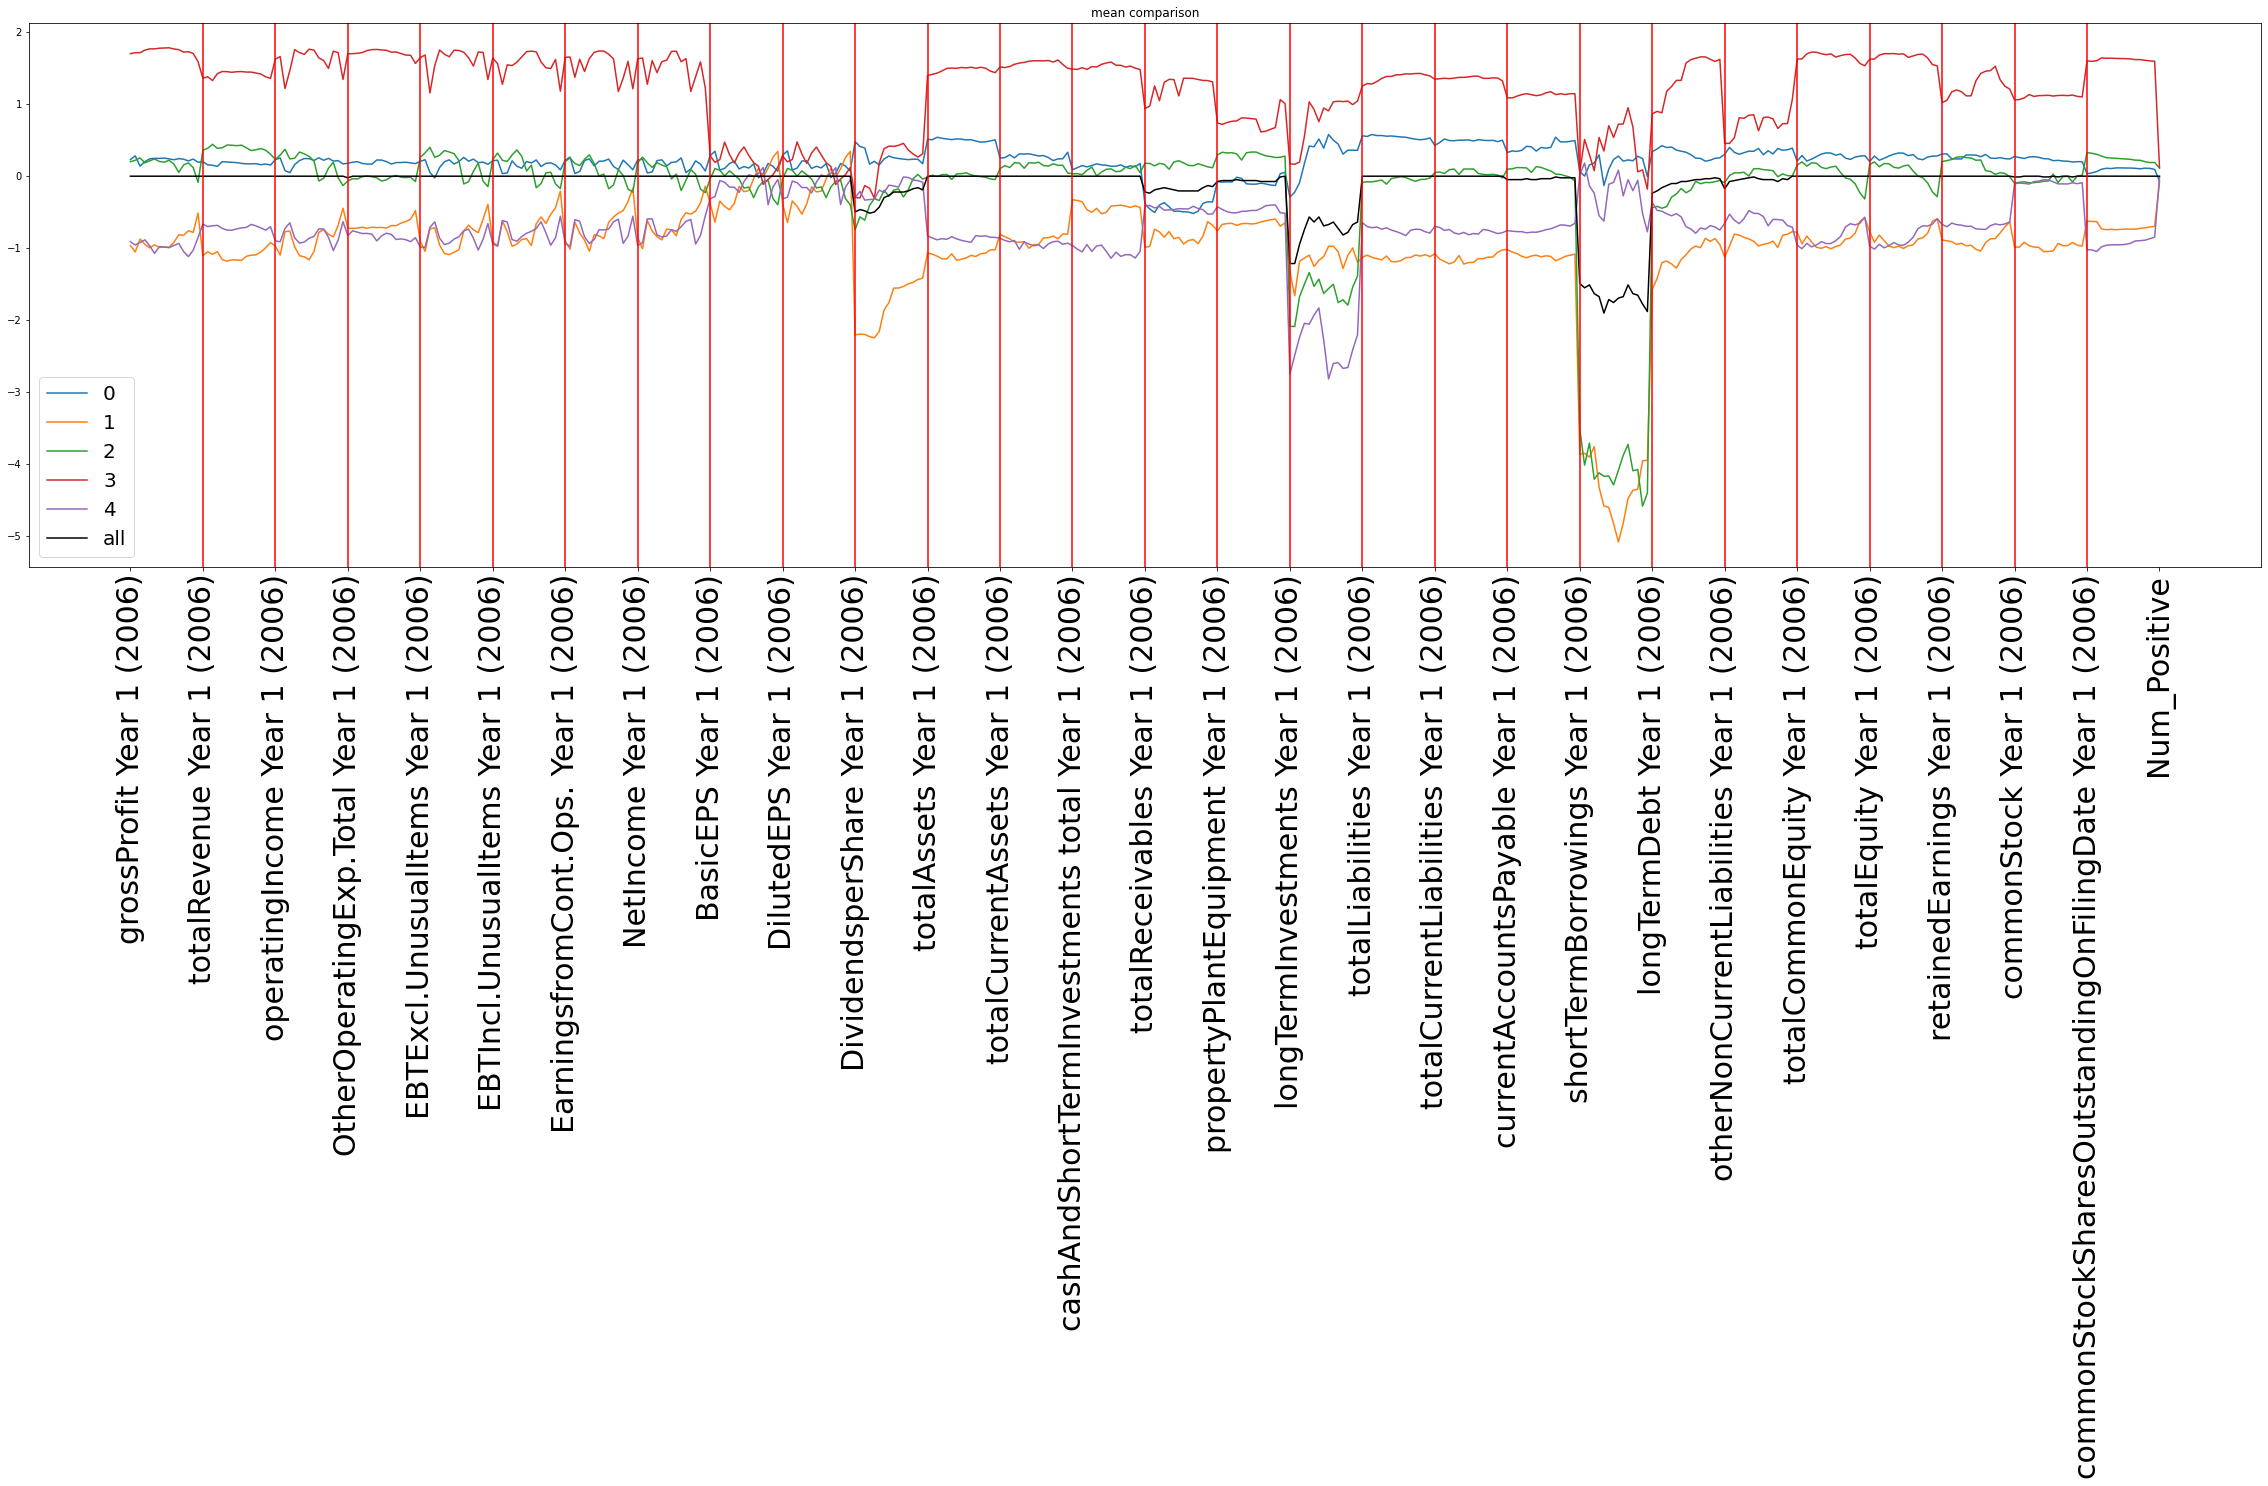

In [26]:
lll = []
for x in range(0,422,15):
    lll.append(x)
list_df = [f0_df,f1_df,f2_df,f3_df,f4_df]

plt.figure(figsize=(40,10))
for x,y in zip(list_df,range(0,5)):
    plt.plot(x.describe().iloc[1], label = '{}'.format(y))
#plt.plot(f1_df.describe().iloc[1],color='g', label = "1")
plt.plot(df_a.describe().iloc[1],color = 'k', label = 'all')
plt.rc('xtick', labelsize=30)
plt.rc('legend',fontsize=20)
plt.xticks(lll,rotation=90)
# plt.axhline(y=0, color='r', linestyle='-')
for xc in range(15,420,15):
    plt.axvline(x=xc,color='r', linestyle='-')
plt.title('mean comparison')
plt.legend()

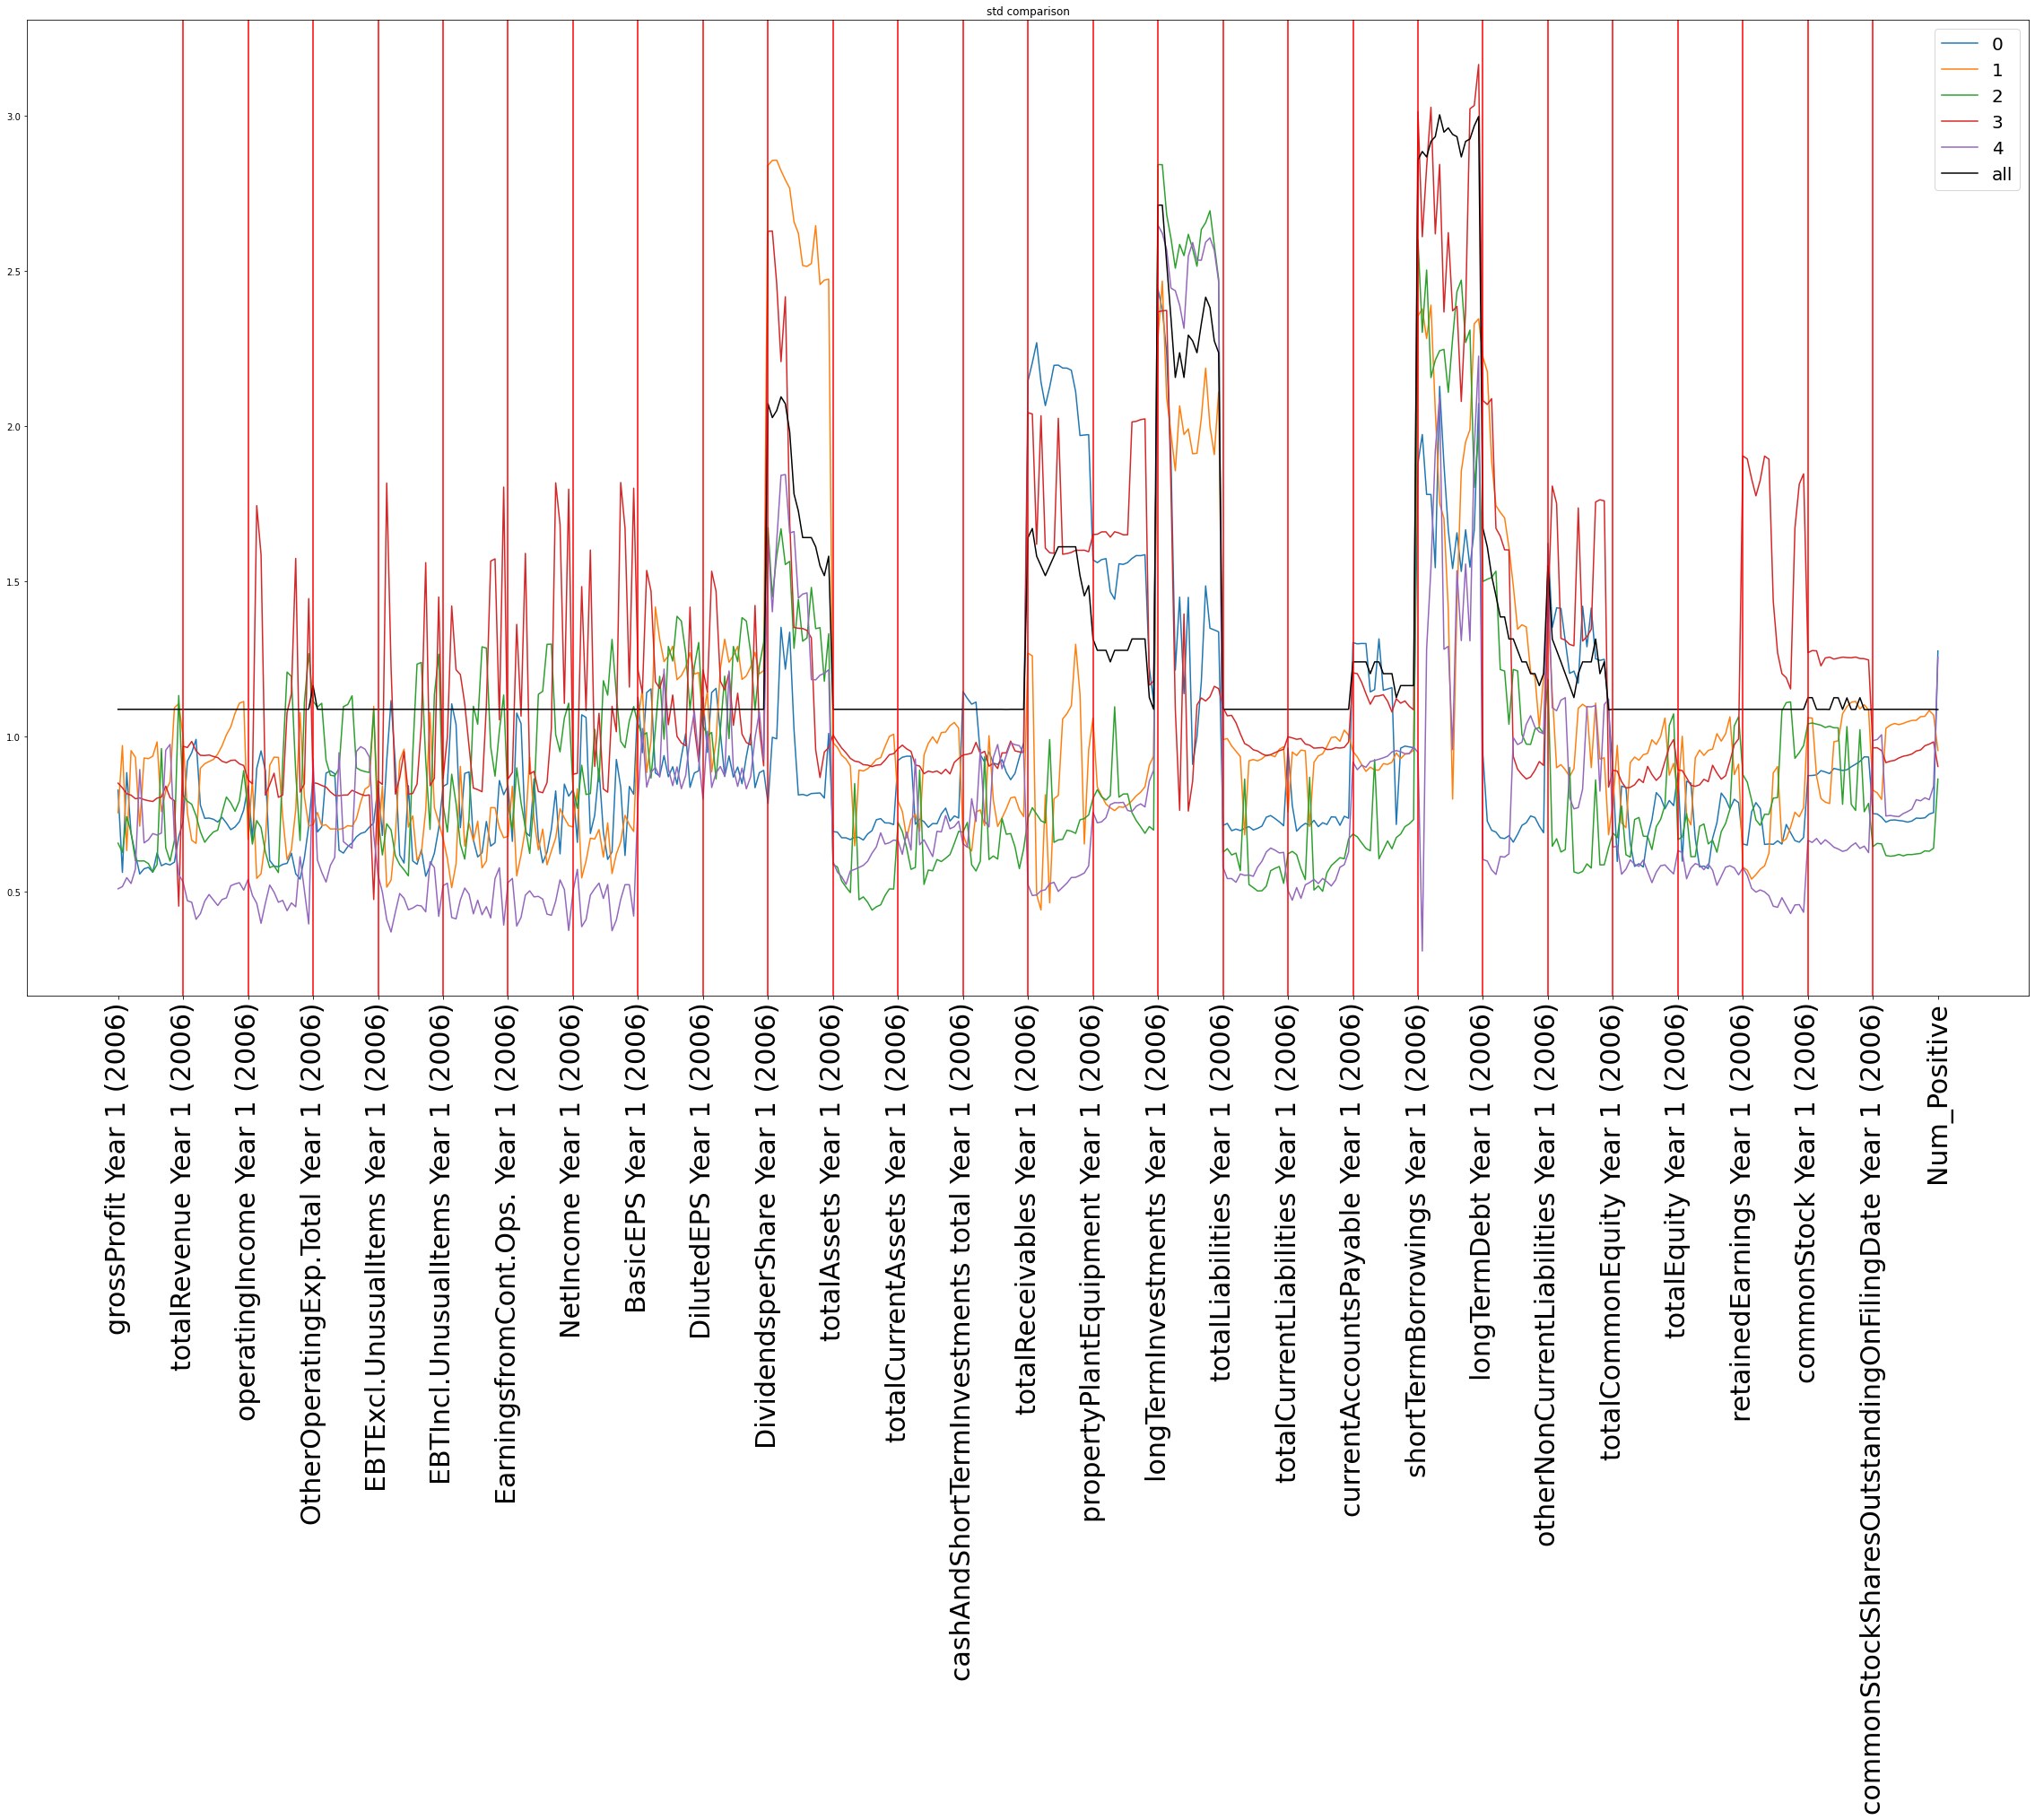

In [27]:
plt.figure(figsize=(40,20))
for x,y in zip(list_df,range(0,5)):
    plt.plot(x.describe().iloc[2], label = '{}'.format(y))
#plt.plot(f1_df.describe().iloc[2],color='g', label = "1")
plt.plot(df_a.describe().iloc[2],color = 'k', label = 'all')
plt.rc('xtick', labelsize=30) 
plt.rc('legend',fontsize=20)
plt.xticks(lll,rotation=90)
# plt.axhline(y=1.087, color='r', linestyle='-')
for xc in range(15,420,15):
    plt.axvline(x=xc,color='r', linestyle='-')
plt.title('std comparison')
plt.legend()

In [25]:
new_list = ['A', 'ADBE', 'ADI', 'ADSK', 'AMD', 'AMZN', 'AZO', 'BBWI', 'BIIB', 'BSX',
       'CTAS', 'CTXS', 'DGX', 'DHI', 'EA', 'EMN', 'EQR', 'FISV', 'IFF', 'INTU',
       'KLAC', 'LEN', 'LH', 'MAR', 'MAS', 'MCO', 'MSI', 'MU', 'NLOK', 'NTAP',
       'NVDA', 'PAYX', 'PKI', 'PLD', 'PSA', 'RHI', 'SPG', 'TPR', 'TROW', 'VMC',
       'VNO', 'WAT', 'YUM', 'ZBH']
old_list =['A', 'ADBE', 'ADI', 'ADSK', 'AMD', 'AMZN', 'AZO', 'BBWI', 'BIIB', 'BSX',
       'CTAS', 'CTXS', 'DGX', 'DHI', 'EA', 'EMN', 'EQR', 'FISV', 'INTU',
       'KLAC', 'LEN', 'LH', 'MAR', 'MAS', 'MCO', 'MSI', 'MU', 'NLOK', 'NTAP',
       'NVDA', 'PAYX', 'PKI', 'PLD', 'PSA', 'RHI', 'SPG', 'TPR', 'TROW', 'VMC',
       'VNO', 'WAT', 'WY', 'YUM', 'ZBH']
for x in old_list:
    if x not in new_list:
        print('deletion:',x)
for x in new_list:
    if x not in old_list:
        print('new addition:',x)

deletion: WY
new addition: IFF
